## Diet-Specific Grocery Item Recommendation

This notebook details our process to cleaning and merging two main datasets: Open Food Facts and Instacart. Based on the products in these datasets, we match items to particular diet categories based on their ingredient content. From there, we create association rules and implement collaborative filtering to generate a consumer specific recommendation system.

# Data Pre-processing
### Import necessary packages and modules

In [17]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 500)
from apyori import apriori 
import networkx as nx
import matplotlib.pyplot as plt
import fuzzywuzzy
import seaborn as sns
#import pydot
import re
%matplotlib inline
from datetime import datetime
from mpl_toolkits.mplot3d import Axes3D
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
import sklearn
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz, DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import IsolationForest
from sklearn import svm
from sklearn.decomposition import TruncatedSVD
from ipywidgets import widgets
import csv

### Datasets:
en.openfoodfacts.org.products.csv - original raw dataset of Open Food Facts Data from Kaggle

foodFacts_reduced.csv - first pass at data cleaning - mainly involved dropping unnecessary columns

foodFacts_reduced2.csv - additional data cleaning - added interpolation removal of missing values
                        also includes addition of diet indicator variables
                        
products.csv, order_products_prior.csv, orders.csv - all components of instacart raw data

fourteen.csv - merged instacart data (prior to merging with open food facts)

food_name1.csv - lookup table

matched_data_right.csv - matched instacart and open food facts data (input into modeling/analysis section)

products_2.csv - maps product id to a matched product name, aisle id, and department id - used as an input into the recommendation system
departments.csv - maps items to a department id used as inputs into the recommendation system

## Original Data

In [25]:
data = pd.read_csv('Open Food Facts.tsv',delimiter='\t')

In [3]:
data.head(5)

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,packaging,packaging_tags,brands,brands_tags,categories,categories_tags,categories_en,origins,origins_tags,manufacturing_places,manufacturing_places_tags,labels,labels_tags,labels_en,emb_codes,emb_codes_tags,first_packaging_code_geo,cities,cities_tags,purchase_places,stores,countries,countries_tags,countries_en,ingredients_text,allergens,allergens_en,traces,traces_tags,traces_en,serving_size,serving_quantity,no_nutriments,additives_n,additives,additives_tags,additives_en,ingredients_from_palm_oil_n,ingredients_from_palm_oil,ingredients_from_palm_oil_tags,ingredients_that_may_be_from_palm_oil_n,ingredients_that_may_be_from_palm_oil,ingredients_that_may_be_from_palm_oil_tags,nutrition_grade_fr,nova_group,pnns_groups_1,pnns_groups_2,states,states_tags,states_en,main_category,main_category_en,image_url,image_small_url,image_ingredients_url,image_ingredients_small_url,image_nutrition_url,image_nutrition_small_url,energy_100g,energy-from-fat_100g,fat_100g,saturated-fat_100g,-butyric-acid_100g,-caproic-acid_100g,-caprylic-acid_100g,-capric-acid_100g,-lauric-acid_100g,-myristic-acid_100g,-palmitic-acid_100g,-stearic-acid_100g,-arachidic-acid_100g,-behenic-acid_100g,-lignoceric-acid_100g,-cerotic-acid_100g,-montanic-acid_100g,-melissic-acid_100g,monounsaturated-fat_100g,polyunsaturated-fat_100g,omega-3-fat_100g,-alpha-linolenic-acid_100g,-eicosapentaenoic-acid_100g,-docosahexaenoic-acid_100g,omega-6-fat_100g,-linoleic-acid_100g,-arachidonic-acid_100g,-gamma-linolenic-acid_100g,-dihomo-gamma-linolenic-acid_100g,omega-9-fat_100g,-oleic-acid_100g,-elaidic-acid_100g,-gondoic-acid_100g,-mead-acid_100g,-erucic-acid_100g,-nervonic-acid_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,-sucrose_100g,-glucose_100g,-fructose_100g,-lactose_100g,-maltose_100g,-maltodextrins_100g,starch_100g,polyols_100g,fiber_100g,proteins_100g,casein_100g,serum-proteins_100g,nucleotides_100g,salt_100g,sodium_100g,alcohol_100g,vitamin-a_100g,beta-carotene_100g,vitamin-d_100g,vitamin-e_100g,vitamin-k_100g,vitamin-c_100g,vitamin-b1_100g,vitamin-b2_100g,vitamin-pp_100g,vitamin-b6_100g,vitamin-b9_100g,folates_100g,vitamin-b12_100g,biotin_100g,pantothenic-acid_100g,silica_100g,bicarbonate_100g,potassium_100g,chloride_100g,calcium_100g,phosphorus_100g,iron_100g,magnesium_100g,zinc_100g,copper_100g,manganese_100g,fluoride_100g,selenium_100g,chromium_100g,molybdenum_100g,iodine_100g,caffeine_100g,taurine_100g,ph_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-estimate_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g
0,0000000000017,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1529059080,2018-06-15T10:38:00Z,1529059204,2018-06-15T10:40:04Z,Vitória crackers,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,France,en:france,France,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"en:to-be-completed, en:nutrition-facts-complet...","en:to-be-completed,en:nutrition-facts-complete...","To be completed,Nutrition facts completed,Ingr...",NaN,NaN,https://static.openfoodfacts.org/images/produc...,https://static.openfoodfacts.org/images/produc...,https://static.openfoodfacts.org/images/produc...,https://static.openfoodfacts.org/images/produc...,NaN,NaN,1569.0,NaN,7.0,3.08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70.1,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.8,NaN,NaN,NaN,1.40,0.551181,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [4]:
data.tail(5)

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,packaging,packaging_tags,brands,brands_tags,categories,categories_tags,categories_en,origins,origins_tags,manufacturing_places,manufacturing_places_tags,labels,labels_tags,labels_en,emb_codes,emb_codes_tags,first_packaging_code_geo,cities,cities_tags,purchase_places,stores,countries,countries_tags,countries_en,ingredients_text,allergens,allergens_en,traces,traces_tags,traces_en,serving_size,serving_quantity,no_nutriments,additives_n,additives,additives_tags,additives_en,ingredients_from_palm_oil_n,ingredients_from_palm_oil,ingredients_from_palm_oil_tags,ingredients_that_may_be_from_palm_oil_n,ingredients_that_may_be_from_palm_oil,ingredients_that_may_be_from_palm_oil_tags,nutrition_grade_fr,nova_group,pnns_groups_1,pnns_groups_2,states,states_tags,states_en,main_category,main_category_en,image_url,image_small_url,image_ingredients_url,image_ingredients_small_url,image_nutrition_url,image_nutrition_small_url,energy_100g,energy-from-fat_100g,fat_100g,saturated-fat_100g,-butyric-acid_100g,-caproic-acid_100g,-caprylic-acid_100g,-capric-acid_100g,-lauric-acid_100g,-myristic-acid_100g,-palmitic-acid_100g,-stearic-acid_100g,-arachidic-acid_100g,-behenic-acid_100g,-lignoceric-acid_100g,-cerotic-acid_100g,-montanic-acid_100g,-melissic-acid_100g,monounsaturated-fat_100g,polyunsaturated-fat_100g,omega-3-fat_100g,-alpha-linolenic-acid_100g,-eicosapentaenoic-acid_100g,-docosahexaenoic-acid_100g,omega-6-fat_100g,-linoleic-acid_100g,-arachidonic-acid_100g,-gamma-linolenic-acid_100g,-dihomo-gamma-linolenic-acid_100g,omega-9-fat_100g,-oleic-acid_100g,-elaidic-acid_100g,-gondoic-acid_100g,-mead-acid_100g,-erucic-acid_100g,-nervonic-acid_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,-sucrose_100g,-glucose_100g,-fructose_100g,-lactose_100g,-maltose_100g,-maltodextrins_100g,starch_100g,polyols_100g,fiber_100g,proteins_100g,casein_100g,serum-proteins_100g,nucleotides_100g,salt_100g,sodium_100g,alcohol_100g,vitamin-a_100g,beta-carotene_100g,vitamin-d_100g,vitamin-e_100g,vitamin-k_100g,vitamin-c_100g,vitamin-b1_100g,vitamin-b2_100g,vitamin-pp_100g,vitamin-b6_100g,vitamin-b9_100g,folates_100g,vitamin-b12_100g,biotin_100g,pantothenic-acid_100g,silica_100g,bicarbonate_100g,potassium_100g,chloride_100g,calcium_100g,phosphorus_100g,iron_100g,magnesium_100g,zinc_100g,copper_100g,manganese_100g,fluoride_100g,selenium_100g,chromium_100g,molybdenum_100g,iodine_100g,caffeine_100g,taurine_100g,ph_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-estimate_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g
745412,9999991149090,http://world-en.openfoodfacts.org/product/9999...,kiliweb,1519146449,2018-02-20T17:07:29Z,1545339064,2018-12-20T20:51:04Z,Riz parfumé,NaN,NaN,NaN,NaN,King Elephant,king-elephant,"Aliments et boissons à base de végétaux, Alime...","en:plant-based-foods-and-beverages,en:plant-ba...","Plant-based foods and beverages,Plant-based fo...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,France,en:france,France,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,b,NaN,Cereals and potatoes,Cereals,"en:to-be-completed, en:nutrition-facts-complet...","en:to-be-completed,en:nutrition-facts-complete...","To be completed,Nutrition facts completed,Ingr...",en:plant-based-foods-and-beverages,Plant-based foods and beverages,https://static.openfoodfacts.org/images/produc...,https://static.openfoodfacts.org/images/produc...,https://static.openfoodfacts.org/images/produc...,https://static.openfoodfacts.org/images/produc...,NaN,NaN,1469.0,NaN,0.5,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,80.0

In [5]:
list(data)

['code',
 'url',
 'creator',
 'created_t',
 'created_datetime',
 'last_modified_t',
 'last_modified_datetime',
 'product_name',
 'generic_name',
 'quantity',
 'packaging',
 'packaging_tags',
 'brands',
 'brands_tags',
 'categories',
 'categories_tags',
 'categories_en',
 'origins',
 'origins_tags',
 'manufacturing_places',
 'manufacturing_places_tags',
 'labels',
 'labels_tags',
 'labels_en',
 'emb_codes',
 'emb_codes_tags',
 'first_packaging_code_geo',
 'cities',
 'cities_tags',
 'purchase_places',
 'stores',
 'countries',
 'countries_tags',
 'countries_en',
 'ingredients_text',
 'allergens',
 'allergens_en',
 'traces',
 'traces_tags',
 'traces_en',
 'serving_size',
 'serving_quantity',
 'no_nutriments',
 'additives_n',
 'additives',
 'additives_tags',
 'additives_en',
 'ingredients_from_palm_oil_n',
 'ingredients_from_palm_oil',
 'ingredients_from_palm_oil_tags',
 'ingredients_that_may_be_from_palm_oil_n',
 'ingredients_that_may_be_from_palm_oil',
 'ingredients_that_may_be_from_palm_

In [26]:
print(data.shape)
print(len(data))
print(data.size)

(356027, 163)
356027
58032401


In [7]:
data.loc[:,'product_name'][0:200]

0                             Vitória crackers
1                                        Cacao
2                        Sauce Sweety chili 0%
3                                    Mini coco
4                        Pistou d'ail des ours
5                                    Pain maïs
6                                    Mendiants
7                    Salade de carottes râpées
8                  Fromage blanc aux myrtilles
9                                          NaN
10                                    Vainilla
11                           Baguette parisien
12               &quot;Baguette Lyonnais&quot;
13                      Solène céréales poulet
14                          Tarte noix de coco
15                  Salade de fruits exotiques
16                            Chouquettes x 30
17                         Fromage blanc pêche
18                      Crème dessert chocolat
19                        Bouillie de sarrasin
20                            Compote de poire
21           

In [8]:
# get the number of missing data points per column
missing_values_count = data.isnull().sum()

# look at the # of missing points in the first ten columns
missing_values_count

code                                        35
url                                         35
creator                                      4
created_t                                    5
created_datetime                            11
last_modified_t                              0
last_modified_datetime                       0
product_name                             34312
generic_name                            660731
quantity                                534346
packaging                               594504
packaging_tags                          594507
brands                                  250319
brands_tags                             250365
categories                              518136
categories_tags                         518134
categories_en                           518169
origins                                 699526
origins_tags                            699587
manufacturing_places                    673890
manufacturing_places_tags               673911
labels       

In [9]:
list(data)

['code',
 'url',
 'creator',
 'created_t',
 'created_datetime',
 'last_modified_t',
 'last_modified_datetime',
 'product_name',
 'generic_name',
 'quantity',
 'packaging',
 'packaging_tags',
 'brands',
 'brands_tags',
 'categories',
 'categories_tags',
 'categories_en',
 'origins',
 'origins_tags',
 'manufacturing_places',
 'manufacturing_places_tags',
 'labels',
 'labels_tags',
 'labels_en',
 'emb_codes',
 'emb_codes_tags',
 'first_packaging_code_geo',
 'cities',
 'cities_tags',
 'purchase_places',
 'stores',
 'countries',
 'countries_tags',
 'countries_en',
 'ingredients_text',
 'allergens',
 'allergens_en',
 'traces',
 'traces_tags',
 'traces_en',
 'serving_size',
 'serving_quantity',
 'no_nutriments',
 'additives_n',
 'additives',
 'additives_tags',
 'additives_en',
 'ingredients_from_palm_oil_n',
 'ingredients_from_palm_oil',
 'ingredients_from_palm_oil_tags',
 'ingredients_that_may_be_from_palm_oil_n',
 'ingredients_that_may_be_from_palm_oil',
 'ingredients_that_may_be_from_palm_

In [10]:
cols = ['product_name','generic_name','quantity','packaging_tags','brands','categories_en','origins','manufacturing_places',
           'labels','cities_tags','purchase_places','stores','countries_en','ingredients_text','allergens','traces_en','serving_size',
           'serving_quantity', 'additives_n', 'additives', 'nutrition_grade_fr','pnns_groups_1','pnns_groups_2','main_category_en',
           'energy_100g','energy-from-fat_100g', 'fat_100g', 'saturated-fat_100g', 'omega-3-fat_100g', 'trans-fat_100g','cholesterol_100g',
           'carbohydrates_100g', 'sugars_100g', '-lactose_100g', 'fiber_100g', 'proteins_100g', 'salt_100g','sodium_100g']
data = data[cols]
data = data[data.countries_en == 'United States']
data.to_csv('foodFacts_reduced.csv')

## Reduced Data

In [54]:
reduced_data = pd.read_csv('foodFacts_reduced.csv')

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (9,21) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [12]:
reduced_data.head()
reduced_data = reduced_data.drop('Unnamed: 0', axis = 1)

In [13]:
list(reduced_data)

['product_name',
 'generic_name',
 'quantity',
 'packaging_tags',
 'brands',
 'categories_en',
 'origins',
 'manufacturing_places',
 'labels',
 'cities_tags',
 'purchase_places',
 'stores',
 'countries_en',
 'ingredients_text',
 'allergens',
 'traces_en',
 'serving_size',
 'serving_quantity',
 'additives_n',
 'additives',
 'nutrition_grade_fr',
 'pnns_groups_1',
 'pnns_groups_2',
 'main_category_en',
 'energy_100g',
 'energy-from-fat_100g',
 'fat_100g',
 'saturated-fat_100g',
 'omega-3-fat_100g',
 'trans-fat_100g',
 'cholesterol_100g',
 'carbohydrates_100g',
 'sugars_100g',
 '-lactose_100g',
 'fiber_100g',
 'proteins_100g',
 'salt_100g',
 'sodium_100g']

In [55]:
#Remove observations where product name is not provided  
print(reduced_data.shape)
reduced_data = reduced_data.dropna(subset=['product_name']).drop_duplicates(subset=['product_name'])
print(reduced_data.shape)

(170452, 81)
(116036, 81)


In [56]:
missing_values_count = reduced_data.isnull().sum().sort_values(ascending=True)

percent_1 = reduced_data.isnull().sum()/reduced_data.isnull().count()*100
percent_2 = round(percent_1,1).sort_values(ascending=True)

missing_data = pd.concat([missing_values_count,percent_2],axis='columns',keys=['Total','%'])
missing_data.head(30)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


,Total,%
additives,1999,1.7
alcohol_100g,115897,99.9
allergens,115555,99.6
biotin_100g,116028,100.0
brands,1083,0.9
caffeine_100g,116003,100.0
calcium_100g,24627,21.2
carbohydrates_100g,2282,2.0
carbonfootprint_100g,116035,100.0
categories_en,113047,97.4


In [22]:
# Select nutrition where percentage of missing values is less than 22%
features = ['carbohydrates_100g','fat_100g','energy_100g','sodium_100g','salt_100g','proteins_100g',
           'sugars_100g','saturated-fat_100g','cholesterol_100g','trans-fat_100g','fiber_100g']

In [23]:
# Statistics before interpolation
[reduced_data[x].describe() for x in features]

KeyError: 'saturated-fat_100g'

In [18]:
# Interpolate null valuess
for x in features:
    reduced_data[x] = reduced_data[x].interpolate()

In [19]:
# Statistics after interpolation
print (list(map(lambda x: reduced_data[x].describe(),features)))

[count    116090.000000
mean         35.443567
std          39.539081
min           0.000000
25%           7.140000
50%          27.270000
75%          62.070000
max        7610.000000
Name: carbohydrates_100g, dtype: float64, count    116090.000000
mean         12.176550
std          17.299971
min           0.000000
25%           0.000000
50%           5.000000
75%          20.000000
max        1880.000000
Name: fat_100g, dtype: float64, count    116090.000000
mean       1156.278722
std        1250.501615
min           0.000000
25%         418.000000
50%        1197.000000
75%        1674.000000
max      231199.000000
Name: energy_100g, dtype: float64, count    116090.000000
mean          2.021290
std         153.994611
min           0.000000
25%           0.027000
50%           0.250000
75%           0.583000
max       39300.000000
Name: sodium_100g, dtype: float64, count    116090.000000
mean          5.134557
std         391.303416
min           0.000000
25%           0.068580
50% 

In [20]:
missing_values_count = reduced_data.isnull().sum().sort_values(ascending=True)

percent_1 = reduced_data.isnull().sum()/reduced_data.isnull().count()*100
percent_2 = round(percent_1,1).sort_values(ascending=True)

missing_data = pd.concat([missing_values_count,percent_2],axis='columns',keys=['Total','%'])
missing_data.head(15)

,Total,%
-lactose_100g,116063,100.0
additives,1818,1.6
additives_n,1815,1.6
allergens,115609,99.6
brands,1137,1.0
carbohydrates_100g,0,0.0
categories_en,113101,97.4
cholesterol_100g,0,0.0
cities_tags,116087,100.0
countries_en,0,0.0


In [21]:
missing_values_count = reduced_data.isnull().sum()

percent_1 = reduced_data.isnull().sum()/reduced_data.isnull().count()*100
percent_2 = round(percent_1,1)

missing_data = pd.concat([missing_values_count,percent_2],axis='columns',keys=['Total','%'])

# Select variables where missing value is less than 20%
desired_columns = (missing_data[missing_data['%']<20]).index.tolist()

reduced_data = reduced_data.loc[:,desired_columns]

In [22]:
list(reduced_data)

['product_name',
 'brands',
 'countries_en',
 'ingredients_text',
 'serving_size',
 'serving_quantity',
 'additives_n',
 'additives',
 'energy_100g',
 'fat_100g',
 'saturated-fat_100g',
 'trans-fat_100g',
 'cholesterol_100g',
 'carbohydrates_100g',
 'sugars_100g',
 'fiber_100g',
 'proteins_100g',
 'salt_100g',
 'sodium_100g']

In [23]:
#Put string variables in lowercase

stringVarList = ['product_name', 'brands', 'countries_en', 'ingredients_text', 'serving_size', 'additives']

for var in stringVarList:
    reduced_data[var] = reduced_data[var].apply(lambda x: str(x).lower())

## TAGGING DIETS

#### Logic on tagging

Vegans do not eat any animal products: this includes the categories meat, dairy, and eggs as well as all variations. For example, this includes shellfish, honey, lard, gelatin, etc.
Some vegans are more strict than others, but we choose to tag the items as stringently as possible.

- Vegan = ingredients_text != 'milk, eggs, whey,butter, cheese,lactose,clam,sardine,oyster,fish,beef,chicken,pork,meat'

Gluten free individuals do not consume any products derived from wheat, oat, barley, and obviously gluten
- Gluten Free - ingredients_text != 'wheat, oat, barley, gluten'

Vegetarians, like vegans, do not consume meat. However they are lenient in their consumption of dairy, eggs, honey, and lard. Vegetarians also do not eat seafood.
- Vegetarian = ingredients != 'meat,beef,chicken,pork, fish, oyster, clam, sardine'

Pescatarians are similar to vegetarians, but consume seafood. They abstain from other types of meat: chicken, beef, pork, etc. They also eat dairy and eggs.
- Pescatarian = ingredients  != 'beef','chicken','pork','meat'

Soy-free consumers do not eat any soy-based products

Dairy-free consumers do not eat any products containing dairy: this includes all derivatives of dairy as well: we tag dairy free based on casein and whey ingredients, lactose, butter, and cheese.

In [25]:
#Create indicator variables for the diet types based on their ingredient content
reduced_data['vegan'] = np.nan
reduced_data.loc[~reduced_data['ingredients_text'].str.contains(
    'eggs|butter|cream|casein|pepperoni|gelatin|whey|milk|cheese|lard|lactose|clam|sardine|oyster|salmon|fish|shrimp|beef|chicken|pork|meat',na=False),'vegan'] = 1

reduced_data['vegetarian'] = np.nan
reduced_data.loc[~reduced_data['ingredients_text'].str.contains(
    'clam|sardine|oyster|pepperoni|fish|shrimp|salmon|beef|chicken|pork|meat',na=False),'vegetarian'] = 1

reduced_data['pescatarian'] = np.nan
reduced_data.loc[~reduced_data['ingredients_text'].str.contains(
    'beef|chicken|pork|meat',na=False),'pescatarian'] = 1

reduced_data['gluten_free'] = np.nan
reduced_data.loc[~reduced_data['ingredients_text'].str.contains(
    'wheat|barley|oats|gluten,|gluten]|flour',na=False),'gluten_free'] = 1

reduced_data['dairy_free'] = np.nan
reduced_data.loc[~reduced_data['ingredients_text'].str.contains(
    'butter|cream|casein|whey|milk|cheese|lactose',na=False),'dairy_free'] = 1

reduced_data['soy_free'] = np.nan
reduced_data.loc[~reduced_data['ingredients_text'].str.contains(
    'soy|soya',na=False),'soy_free'] = 1


In [26]:
# View result
reduced_data[['product_name','ingredients_text','vegan','vegetarian','pescatarian','gluten_free', 'dairy_free', 'soy_free']][:5]

,product_name,ingredients_text,vegan,vegetarian,pescatarian,gluten_free,dairy_free,soy_free
0,banana chips sweetened (whole),"bananas, vegetable oil (coconut oil, corn oil ...",1.0,1.0,1.0,1.0,1.0,1.0
1,peanuts,"peanuts, wheat flour, sugar, rice flour, tapio...",1.0,1.0,1.0,NaN,1.0,NaN
2,organic salted nut mix,"organic hazelnuts, organic cashews, organic wa...",1.0,1.0,1.0,1.0,1.0,1.0
3,organic polenta,organic polenta,1.0,1.0,1.0,1.0,1.0,1.0
4,breadshop honey gone nuts granola,"rolled oats, grape concentrate, expeller press...",1.0,1.0,1.0,NaN,1.0,1.0


#### Export reduced_data to csv 

In [7]:
reduced_data.to_csv("foodFacts_reduced2.csv", index=False)

# Merge Datasets
#### Import reduced data

In [6]:
reduced_data2 = pd.read_csv('foodFacts_reduced2.csv')

#### Import Instacart data

In [8]:
#The instacart data is organized into three groups: products, orders, and prior orders
products = pd.read_csv("products.csv")
prior = pd.read_csv("order_products__prior.csv")
orders = pd.read_csv("orders.csv")

In [32]:
#looking at first 400 orders only!
order_100 = orders.sort_values('order_id').head(4000)
instacart  = pd.merge(order_100, prior, on = 'order_id')
instacart  = pd.merge(instacart,products, on = 'product_id')

In [34]:
print(instacart.shape)
instacart.head(3)
instacart = instacart.drop('product_name',axis=1)

(38084, 14)


In [35]:
#cleaning up the data by dropping variables we don't need
instacart = instacart.drop('order_hour_of_day',axis=1)
instacart = instacart.drop('days_since_prior_order',axis=1)
instacart = instacart.drop('department_id',axis=1)
instacart = instacart.drop('aisle_id',axis=1)
instacart = instacart.drop('add_to_cart_order',axis=1)
#instacart = instacart.drop('department_id',axis=1)
#instacart = instacart.drop('aisle_id',axis=1)
#instacart = instacart.drop('add_to_cart_order',axis=1)

In [36]:
#only looking at unique names
insta_unique = instacart.product_name_insta.unique()

In [37]:
#getting rid of the word organic
    #The word organic prevents string matching because it is used in the IC data but not in the OFF data
reduced_data['product_name_reduced'] = reduced_data['product_name'].str.lower()
reduced_data['product_name_reduced']= reduced_data['product_name_reduced'].str.replace('organic ','')

In [38]:
#losing duplicates 
reduced_data = reduced_data.drop_duplicates('product_name_reduced')

In [39]:
#getting rid of redundant columns - we already have reduced and instacart specific variables for product name
reduced_data=reduced_data.drop('product_name',axis=1)

In [9]:
#fuzzy matching to create a look up table so we can merge datasets 
from fuzzywuzzy import process
name=[]
for n in insta_unique[701:1400]:
    highest = process.extractOne(n,OpenFoodFacts_name)
    print(highest)
    name.append(highest[0])

In [ ]:
#saving our file
#with open('fourteen.csv', 'w') as csvFile:
    #writer = csv.writer(csvFile)
    #writer.writerows(name)

#csvFile.close()

In [ ]:
#reading our lookup table
lookup = pd.read_csv('C:/Users/Daniel Tallarico/Downloads/food_name1.csv',encoding='latin-1')
lookup.head(100)

In [ ]:
#merging the lookup table and the instacart table
x  = pd.merge(instacart,lookup,on='product_name_insta')

In [ ]:
#renaming columns
x = x.rename(columns={"Matched_name":"product_name_reduced"})
x.head(2000)

In [ ]:
#creating our final table
Final = pd.merge(reduced_data,x,on="product_name_reduced")

In [ ]:
#changing the index to product name
Final.set_index('product_name_reduced')

In [ ]:
Final.to_csv('matched_data_right.csv',index=False)

# Analysis
## Recommendation System

Failed to display Jupyter Widget of type VBox.

If you're reading this message in the Jupyter Notebook or JupyterLab Notebook, it may mean that the widgets JavaScript is still loading. If this message persists, it likely means that the widgets JavaScript library is either not installed or not enabled. See the Jupyter Widgets Documentation for setup instructions.

If you're reading this message in another frontend (for example, a static rendering on GitHub or NBViewer), it may mean that your frontend doesn't currently support widgets.

In [46]:
# Load data
matched = pd.read_csv("matched_data_right.csv")
# matched.head()
matched[['product_name_reduced','product_id']].drop_duplicates('product_name_reduced')[:30]

,product_name_reduced,product_id
0,banana chips sweetened (whole),33506
1,penne pasta,12036
15,quinoa coconut granola with mango,46077
18,peanut butter power chews,38782
20,real salt granular,35134
21,coconut chips,12023
25,black beans,27156
116,dark chocolate sea salt & turbinado almonds,45253
118,garbanzo beans,35750
172,baby lima beans,15649


In [47]:
origin = widgets.Dropdown(
    options=matched['product_name_reduced'].unique().tolist(),
    value='penne pasta',
    description='Fav Food: ',
    disabled=False
)


type1 = widgets.RadioButtons(
    options=['vegetarian', 'pescatarian', 'vegan','gluten_free'],
    description='Diet type:',
    disabled=False
)


container2 = widgets.HBox([origin,type1])
widgets.VBox([container2])

In [62]:
#dept name 
dpt = pd.read_csv("products.csv")
dptn = pd.read_csv("departments.csv")
dptn.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [63]:
# type in any kind of product that you like, and list of diets
recp = findSimilar(3849,'vegetarian')
recp

,product_id,pd_name
0,604,Cookie Sheets
1,1183,Organic Black Seedless Grapes
2,2846,Organic Green Onions
3,2929,Coconut Aminos Teriyaki Sauce
4,2994,"Sushi Nori, Pacific, Organic"
5,5652,Organic Red Potatoes
6,5699,Gluten Free Mushroom Risotto Bowl
7,5959,Four Cheese Thin Crust Pizza
8,7308,Organic Hazelnut Spread
9,8186,"Baby Food Pouch - Butternut Squash, Carrot & C..."


In [68]:
def findNut(foodid,eatinghabbit):
    vegnut = matched[['serving_size', 'num_additives', 
       'ingredients_from_palm_oil_n', 'ingredients_that_may_be_from_pal',
       'energy_100g', 'fat_100g', 'saturatedfat_100g', 'transfat_100g',
       'cholesterol_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g',
       'proteins_100g', 'salt_100g', 'sodium_100g', 'vitamina_100g',
       'vitaminc_100g', 'calcium_100g', 'iron_100g','product_id', eatinghabbit]]
    vegnut = vegnut.loc[vegnut[eatinghabbit] == 1]
    vegnut = vegnut.drop([eatinghabbit],1)
    vegnut = vegnut.drop_duplicates(keep='first')
    vegnut = vegnut.dropna(subset=['serving_size'])
    vegnut['serving_size'] = vegnut.serving_size.str.split('(').str[0]
    vegnut['size'] = vegnut.serving_size.str.split(" ").str[1]
    vegnut['amount'] = vegnut.serving_size.str.split(" ").str[0]
    vegnut['unsplited'] = vegnut.amount.str.replace('[^a-zA-Z]', '')
    vegnut['amount'] = vegnut.amount.str.replace('[a-zA-Z]', '')
    vegnut.loc[vegnut['size'].isnull(), 'unsplited']
    vegnut['size'] = vegnut['size'].map({'g':'g', 'ml':'ml','Tsp':'tsp','cup,': 'cup', 'mL': 'ml','Tbsp.': 'tbsp','pieces':'pieces','cup':'cup','slices':'slices','tbsp':'tbsp'})
    vegnut = pd.get_dummies(vegnut, columns=['size'], prefix = ['size'])
    vegnut = vegnut.drop(['serving_size','unsplited','amount'],1)
    y = vegnut['product_id']
    vegnut = vegnut.drop(['product_id'],1)
    vegnut = vegnut.fillna(0)
    #Cluster the data
    kmeans = KMeans(n_clusters=4, random_state=10).fit(vegnut)
    labels = kmeans.labels_

    #Glue back to originaal data
    vegnut['clusters'] = labels
    y = y.astype(str)
    vegnut = vegnut.join(y)
    cls = vegnut.loc[vegnut.product_id == foodid,'clusters'].values[0]
    vegnut = vegnut[vegnut['clusters']==cls]
    result = vegnut['product_id']
    return result

In [69]:
recn = findNut('3849','vegetarian')
recn.head(20)

0      33506
1      12036
6      14168
15     46077
16     39636
18     38782
20     35134
116    45253
183    20142
185    43511
186    32734
203    14477
206    45312
208    17889
210    37710
334    15902
364    17568
371    42579
378     7010
389    48002
Name: product_id, dtype: object

In [70]:
def findCommon(recp,recn):
    recn = pd.DataFrame(recn)
    recp = pd.DataFrame(recp)
    recp['product_id'] = recp['product_id'].astype(str)
    recp = recp.merge(recn,left_on = 'product_id',right_on = 'product_id',how='inner')
    recp = recp.drop_duplicates(keep='first')
    return recp
finalrec = findCommon(recp,recn)
finalrec

,product_id,pd_name
0,604,Cookie Sheets
1,2994,"Sushi Nori, Pacific, Organic"
2,5699,Gluten Free Mushroom Risotto Bowl
3,7308,Organic Hazelnut Spread
4,8953,Key Limes
5,11132,Organic Promise Berry Fruitful Cereal
6,14032,Tortilla Chips
7,22474,Cheddar Bunnies Snack Crackers
8,25331,Chocolate Malt
9,26521,Organic Grass-Fed Classic Mild Cheddar Macaron...


In [67]:
# learned from the research:
# input would be in text, fuzzywuzzy match for product_id first
# we can change SVD features
# KNN can be stored somewhere in a dictionary and that would be efficient if not a lot of new items being added
# limit # of recommendations
# probably send out coupon  based on this recommendation
# also we can make recommendation on food you hate (eliminate those from the list)

## Association Rule Mining:
### Apriori Algorithm

In [20]:
#Using the matched data, create a pivot table with the instacart products as column headers, 
# as rows, and product names from the reduced OFF data as the values of the table
data = pd.read_csv('matched_data_right.csv')
df = data.pivot(index='order_id', columns='product_name_insta', values='product_name_reduced')
df

In [44]:
#Create a list of records (items and products) that will enter into the apriori algorithm,
#which will determine all possible combinations and sort them based on support, confidence, and lift
records = []  
for i in range(0, len(df)):  
    records.append([str(df.values[i,j]) for j in range(0, len(df.columns))])

In [61]:
#Generate the association rules using the apriori algorithm
#We set the parameter values accordingly:
    #min_support 0.015
    #min_confidence 0.55
    #min_lift 3
    #min_length 2
#We test various different parameter combinations, but ultimately decide on this for speed/computation
#The algorithm performs quickly under this list and still provides a generous amount of association rules

association_rules = list(apriori(records, min_support=0.015, min_confidence=0.55, min_lift=3, min_length=3))
len(association_rules)

156

In [ ]:
for item in association_rules:

    # first index of the inner list
    # Contains base item and add item
    pair = item[0] 
    items = [x for x in pair]
    print("Rule: " + items[0] + " -> " + items[1])

    #second index of the inner list
    print("Support: " + str(item[1]))

    #third index of the list located at 0th
    #of the third index of the inner list

    print("Confidence: " + str(item[2][0][2]))
    print("Lift: " + str(item[2][0][3]))
    print("=====================================")
    print("                                     ")

Since this runs slow, lets try a more efficient way! We can use  PySpark!

In [21]:
#Lets import some pyspark functions we will need
from pyspark.sql import SparkSession
from pyspark.sql import HiveContext
from pyspark.sql import functions as F
from pyspark.sql.functions import upper, col
from pyspark.sql import SQLContext
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

In [23]:
#creating our context
spark = SparkSession.builder.appName('DMP').getOrCreate()
sc = spark.sparkContext # Local spark context
sql_sc = SQLContext(sc)

In [24]:
#file
BD_Local_File = 'matched_data_right.csv'

In [25]:
#reading the csv directly into pyspark
df = (spark.read
.option("header", "true")
.option("inferSchema", "true")
.option("multiLine", "true")
.option("delimiter", ",")
.format("csv")
.load(BD_Local_File)) 

In [41]:
#checking our dataframe
df.show(2)

+----------+-------------+--------------------+--------------+----------------+-------------+--------------------+---------------------------+--------------------------------+-----------+--------+------------------+-------------+----------------+------------------+-----------+----------+-------------+---------+-----------+--------------------+-------------+-------------------+---------+-----+----------+-----------+-----------+-----------+--------+--------------------+--------+-------+--------+------------+---------+----------+---------+--------------------+
|    brands| countries_en|    ingredients_text|  serving_size|serving_quantity|num_additives|           additives|ingredients_from_palm_oil_n|ingredients_that_may_be_from_pal|energy_100g|fat_100g| saturatedfat_100g|transfat_100g|cholesterol_100g|carbohydrates_100g|sugars_100g|fiber_100g|proteins_100g|salt_100g|sodium_100g|       vitamina_100g|vitaminc_100g|       calcium_100g|iron_100g|vegan|vegetarian|pescatarian|gluten_free|high_s

In [27]:
#creating what wach basket will consist of
from pyspark.sql.functions import collect_set, col, count
baskets = df.groupBy(['user_id','order_id']).agg(collect_set('product_name_reduced').alias('items'))
baskets.createOrReplaceTempView('baskets')
baskets.show(truncate=False)

+-------+--------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|user_id|order_id|items                                                                                                                                                                                                                                                                                                                                                                                            |
+-------+--------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [34]:
#importing FGPGrowth
from pyspark.ml.fpm import FPGrowth

#set the minimum thresholds for support and confidence
fpGrowth = FPGrowth(itemsCol="items", minSupport=0.005, minConfidence=.005)

model = fpGrowth.fit(baskets)

#Calculate frequent itemsets
mostPopularItemInABasket = model.freqItemsets
mostPopularItemInABasket.createOrReplaceTempView("mostPopularItemInABasket")

In [35]:
rows = spark.sql('''
select count(*) as rows from mostPopularItemInABasket
''')
rows.show()

+----+
|rows|
+----+
| 446|
+----+



In [36]:
#Looking at common baskets with more than 2 items
spark.sql('''select items, freq from mostPopularItemInABasket 
          where size(items) > 2 order by freq desc limit 20''').show(truncate =False)

+-----------------------------------------+----+
|items                                    |freq|
+-----------------------------------------+----+
|[avocado, strawberries, banana]          |28  |
|[lemon, hass avocados, bananas]          |24  |
|[raspberries, hass avocados, bananas]    |24  |
|[raspberries, strawberries, bananas]     |22  |
|[hass avocados, strawberries, banana]    |21  |
|[hass avocados, strawberries, bananas]   |20  |
|[blackberries, raspberries, strawberries]|20  |
|[avocado, baby spinach, banana]          |18  |
|[raspberries, strawberries, banana]      |18  |
+-----------------------------------------+----+



In [39]:
#sorting the results by confidence
model.associationRules.orderBy("lift", ascending=False).show(5, truncate=False)

+----------------------------+------------------------------+-------------------+-----------------+
|antecedent                  |consequent                    |confidence         |lift             |
+----------------------------+------------------------------+-------------------+-----------------+
|[raspberries, strawberries] |[blackberries]                |0.25316455696202533|8.53631559542829 |
|[blackberries, strawberries]|[raspberries]                 |0.5                |7.175619834710744|
|[key limes mini cookies]    |[bun]                         |0.11688311688311688|6.150531286894924|
|[bun]                       |[key limes mini cookies]      |0.2727272727272727 |6.150531286894923|
|[key limes mini cookies]    |[zesty cilantro salsa, medium]|0.12337662337662338|5.423886240341937|
+----------------------------+------------------------------+-------------------+-----------------+
only showing top 5 rows



In [40]:
#sort by confidence
model.associationRules.orderBy("confidence", ascending=False).show(5, truncate=False)

+-----------------------------------+--------------+-------------------+------------------+
|antecedent                         |consequent    |confidence         |lift              |
+-----------------------------------+--------------+-------------------+------------------+
|[blackberries, raspberries]        |[strawberries]|0.6451612903225806 |4.747129579004921 |
|[unsweetened almond-milk, original]|[banana]      |0.5116279069767442 |2.9964312325973568|
|[blackberries, strawberries]       |[raspberries] |0.5                |7.175619834710744 |
|[raspberries, hass avocados]       |[bananas]     |0.47058823529411764|3.3218555714968914|
|[avocado, strawberries]            |[banana]      |0.4375             |2.562289207419899 |
+-----------------------------------+--------------+-------------------+------------------+
only showing top 5 rows



## Graph Based Modeling

In [73]:
#Import data and build graph with order numbers as nodes connected to vegetarian indicator:
    #This graph shows the grouping of orders matched to vegetarian and non-vegetarian products

#FG = nx.from_pandas_edgelist(data, source='order_id', target='reordered', edge_attr=False,)
#FG = nx.from_pandas_edgelist(data, source='order_number', target='vegan', edge_attr=False,)
FG = nx.from_pandas_edgelist(data, source='order_number', target='vegetarian', edge_attr=False,)
#FG = nx.from_pandas_edgelist(data, source='user_id', target='pescatarian', edge_attr=False,)

EdgeView([(19, 1.0), (19, nan), (1.0, 9), (1.0, 21), (1.0, 8), (1.0, 13), (1.0, 29), (1.0, 20), (1.0, 7), (1.0, 4), (1.0, 16), (1.0, 22), (1.0, 6), (1.0, 14), (1.0, 51), (1.0, 15), (1.0, 3), (1.0, 42), (1.0, 94), (1.0, 1.0), (1.0, 54), (1.0, 2), (1.0, 18), (1.0, 25), (1.0, 36), (1.0, 31), (1.0, 49), (1.0, 5), (1.0, 11), (1.0, 47), (1.0, 39), (1.0, 55), (21, nan), (8, nan), (8, nan), (13, nan), (13, nan), (29, nan), (29, nan), (20, nan), (4, nan), (4, nan), (16, nan), (3, nan), (3, nan), (3, nan), (54, nan), (2, nan), (2, nan), (25, nan), (31, nan), (31, nan), (49, nan), (5, nan), (5, nan), (39, nan), (39, nan)])

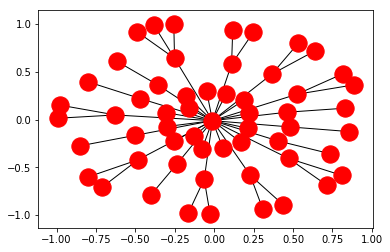

In [70]:
#Draw network
nx.draw_networkx(FG, with_labels=False) # Quick view of the Graph. 

(-1.0811101149198026,
 1.058620767385125,
 -1.1070641176025358,
 1.0113448928220066)

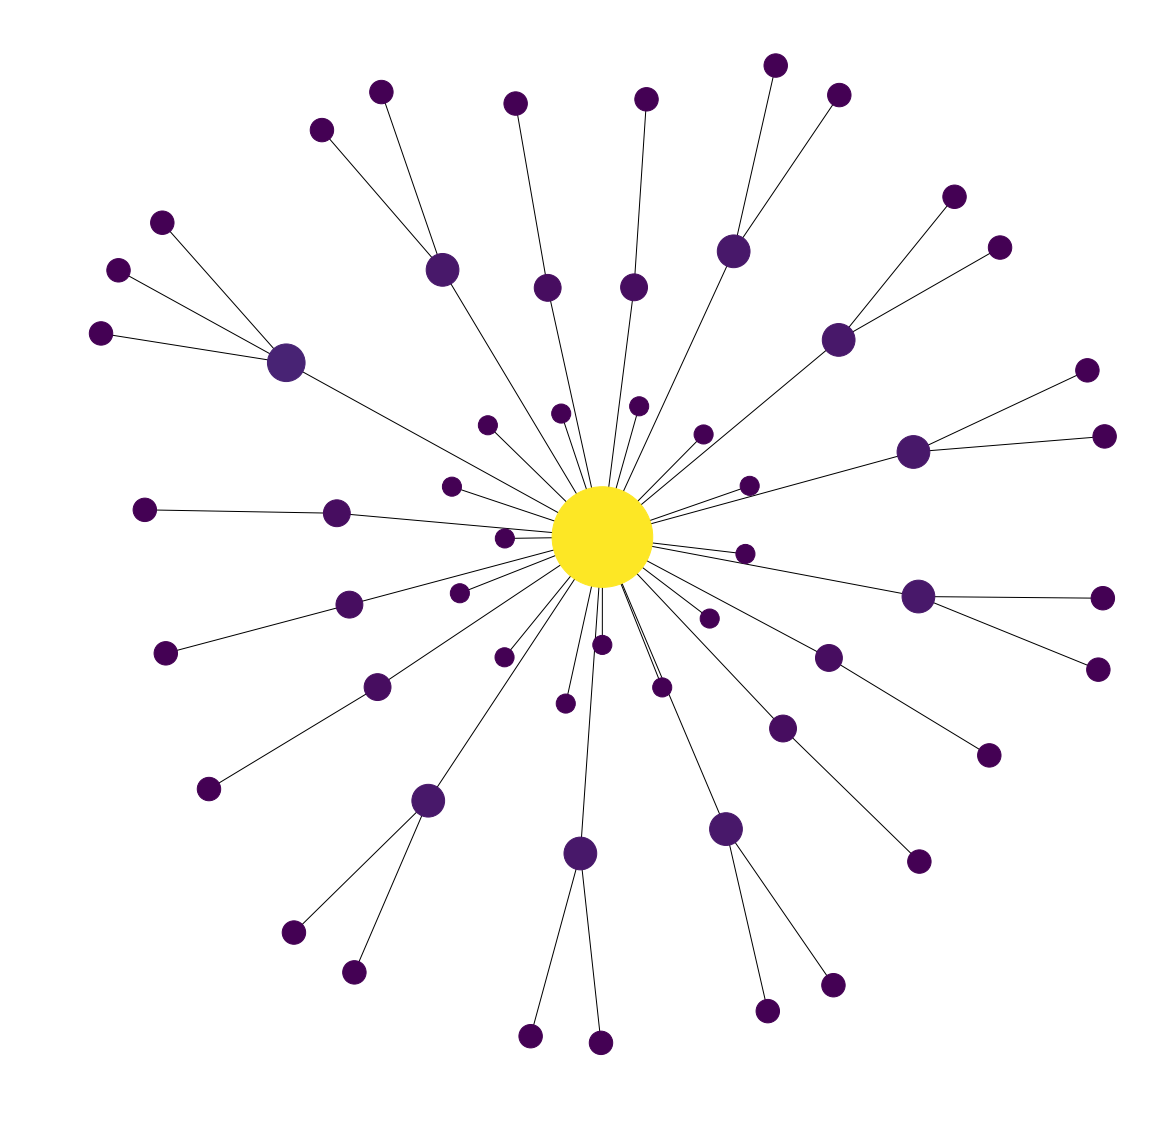

In [71]:
#Create graph
pos = nx.spring_layout(FG)
betCent = nx.betweenness_centrality(FG, normalized=True, endpoints=True)
node_color = [20000.0 * FG.degree(v) for v in FG]
node_size =  [v * 10000 for v in betCent.values()]
plt.figure(figsize=(20,20))
nx.draw_networkx(FG, pos=pos, with_labels=False,
                 node_color=node_color,
                 node_size=node_size )
plt.axis('off')